<a href="https://colab.research.google.com/github/pauldebayan/SpectaGen/blob/main/SpectaGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchvision.io import read_image
import matplotlib.pyplot as plt
import torchvision
import torch
from torch import nn
import os
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

In [4]:
!wget https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/labels.csv
!wget https://github.com/pauldebayan/SpectaGen/raw/refs/heads/main/spectacle_dataset.zip && \
unzip spectacle_dataset.zip

--2024-10-05 14:43:23--  https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/labels.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15893 (16K) [text/plain]
Saving to: ‘labels.csv’

labels.csv          100%[===================>]  15.52K  --.-KB/s    in 0s      

2024-10-05 14:43:23 (120 MB/s) - ‘labels.csv’ saved [15893/15893]

--2024-10-05 14:43:23--  https://github.com/pauldebayan/SpectaGen/raw/refs/heads/main/spectacle_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pauldebayan/SpectaGen/refs/heads/main/spectacle_dataset.zip [following]
--2024-10-05 14:

In [5]:
!ls

labels.csv  sample_data  spectacle_dataset  spectacle_dataset.zip


In [6]:
def ImagesToDelete():
    # To check all the images is of same shape
    channel, height, width = 3, 256, 512

    imagesToDelete = []

    for i in range(1000):
        img = read_image(f'./spectacle_dataset/specs{(i+1)}.jpg')

        if(img.shape[0] != 3 or img.shape[1] != 256 or img.shape[2] != 512):
            imagesToDelete.append(f'specs{(i+1)}.jpg')

    # We need to delete this images as they do not have the desired shape - [3, 256, 512]
    return imagesToDelete

print(ImagesToDelete())


[]


In [7]:
# Check if GPU is available and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 20, 2)
        self.conv2 = nn.Conv2d(20, 10, 2)
        self.conv3 = nn.Conv2d(10, 10, 2)

        self.activ = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.linear_stack = nn.Sequential(
            nn.Linear(19530, 2000),
            nn.LeakyReLU(),
            nn.Linear(2000,800),
            nn.LeakyReLU(),
            nn.Linear(800,400),
            nn.LeakyReLU(),
            nn.Linear(400, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.pool(self.activ(self.conv1(x)))
        x = self.pool(self.activ(self.conv2(x)))
        x = self.pool(self.activ(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)

        x = self.linear_stack(x)

        #return x.shape
        return x


In [9]:
class Genearator(nn.Module):

    def __init__(self):
        super().__init__()


        self.gen_sequence = nn.Sequential(
            nn.ConvTranspose2d(64, 512, 3, stride=2),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(512, 256, 4, stride=2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(256, 128, 4, stride=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 3, 4, stride=2),
            nn.Tanh()
        )


    def forward(self, x):

        x = x.view(1, 64, 30, 62)
        #print(f'x.view(-1, 8, 8) shape: {x}')

        x = self.gen_sequence(x)
        return x


In [10]:
generator = Genearator()
generator = generator.to(device)
discriminator = Discriminator()
discriminator = discriminator.to(device)

print(discriminator)
print(generator)

Discriminator(
  (conv1): Conv2d(3, 20, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(20, 10, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(2, 2), stride=(1, 1))
  (activ): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (linear_stack): Sequential(
    (0): Linear(in_features=19530, out_features=2000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=2000, out_features=800, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=800, out_features=400, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=400, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Genearator(
  (gen_sequence): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [11]:
# To get the input of the linear layer in Discriminator

img = read_image('./spectacle_dataset/specs1.jpg')
print(img.shape)
# print(discriminator(img.float()))
# 19530

torch.Size([3, 256, 512])


In [12]:
def generateNoise():
    noise = torch.randn(1, 119040)
    return noise

# Conv2d: (N-K+1)/S
# ConvTranspose2d: (N-1)*S+K

torch.Size([1, 3, 256, 512])
Fake image shape: torch.Size([1, 3, 256, 512])


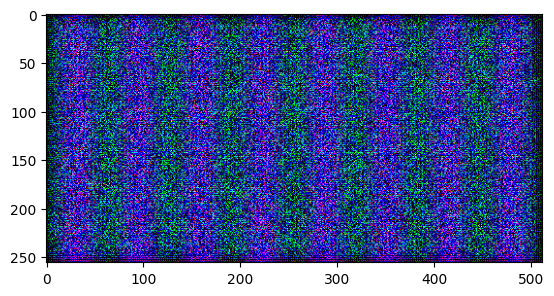

In [13]:
noise = generateNoise()
noise = noise.to(device)
img = generator(noise)

img = img.to(device)

print(img.shape)
plt.imshow(img.cpu().squeeze().detach().permute(1, 2, 0))

print(f"Fake image shape: {img.shape}")


In [14]:
# Real Images - set dataloader
class SpectDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


In [15]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Grayscale()
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = SpectDataset(img_dir = 'spectacle_dataset',
                             annotations_file = 'labels.csv',
                             transform = transform)

batch_size = 5
dl = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
epochs = 10000000
lr = 0.0001

In [17]:
loss_fn = nn.BCELoss()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

Epoch1: Discriminator Loss: 2.6784644433064386e-05, Generator Loss: 10.414331436157227
Epoch1: Discriminator Loss: 0.00022202474065124989, Generator Loss: 10.560125350952148
Epoch1: Discriminator Loss: 0.00010804414341691881, Generator Loss: 9.734709739685059
Epoch1: Discriminator Loss: 0.0007652364438399673, Generator Loss: 9.74087142944336
Epoch1: Discriminator Loss: 0.00032923315302468836, Generator Loss: 10.012508392333984
Epoch1: Discriminator Loss: 0.0001398735330440104, Generator Loss: 8.894094467163086
Epoch1: Discriminator Loss: 0.0001753416727297008, Generator Loss: 8.95730972290039
Epoch1: Discriminator Loss: 0.0003398206317797303, Generator Loss: 8.320038795471191
Epoch1: Discriminator Loss: 0.00025021584588102996, Generator Loss: 8.192436218261719
Epoch1: Discriminator Loss: 0.00023402515216730535, Generator Loss: 7.161282062530518
Epoch1: Discriminator Loss: 0.00014262674085330218, Generator Loss: 6.621534824371338
Epoch1: Discriminator Loss: 0.001441812259145081, Generat

Epoch1: Discriminator Loss: 0.00044782451004721224, Generator Loss: 7.101734638214111
Epoch1: Discriminator Loss: 0.0007382075418718159, Generator Loss: 7.392166614532471


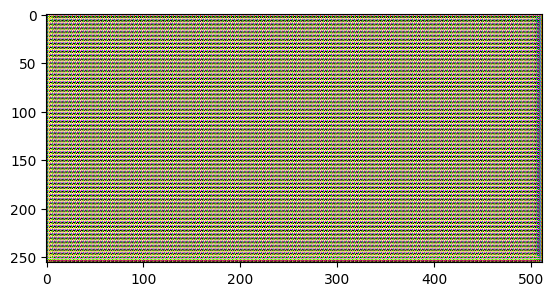

Epoch2: Discriminator Loss: 8.691069524502382e-05, Generator Loss: 11.455926895141602
Epoch2: Discriminator Loss: 4.687975160777569e-05, Generator Loss: 8.280011177062988
Epoch2: Discriminator Loss: 0.0013983824755996466, Generator Loss: 11.153607368469238
Epoch2: Discriminator Loss: 0.0003269480948802084, Generator Loss: 10.463740348815918
Epoch2: Discriminator Loss: 0.00011941659613512456, Generator Loss: 11.421619415283203
Epoch2: Discriminator Loss: 0.0002740297932177782, Generator Loss: 11.39219856262207
Epoch2: Discriminator Loss: 0.0006391339702531695, Generator Loss: 8.388705253601074
Epoch2: Discriminator Loss: 0.006176946219056845, Generator Loss: 4.901700973510742
Epoch2: Discriminator Loss: 0.0007196363294497132, Generator Loss: 12.011611938476562
Epoch2: Discriminator Loss: 0.14785505831241608, Generator Loss: 14.120173454284668
Epoch2: Discriminator Loss: 2.125864028930664, Generator Loss: 0.0002610428200569004
Epoch2: Discriminator Loss: 0.000757025380153209, Generator L

Epoch11: Discriminator Loss: 0.00012691864685621113, Generator Loss: 8.606164932250977


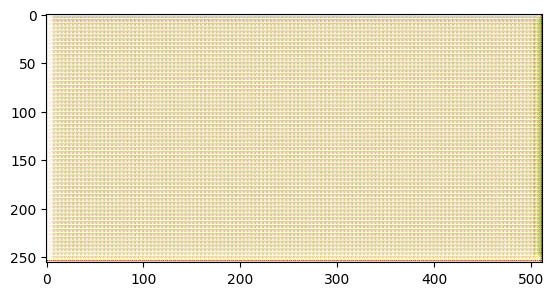

Epoch12: Discriminator Loss: 0.0006085627246648073, Generator Loss: 9.152504920959473
Epoch12: Discriminator Loss: 0.00033936178078874946, Generator Loss: 8.523355484008789
Epoch12: Discriminator Loss: 7.17598813935183e-05, Generator Loss: 8.39212417602539
Epoch12: Discriminator Loss: 0.0001910949358716607, Generator Loss: 9.171832084655762
Epoch12: Discriminator Loss: 2.2830739908386022e-05, Generator Loss: 9.107736587524414
Epoch12: Discriminator Loss: 0.00015357726078946143, Generator Loss: 8.695772171020508
Epoch12: Discriminator Loss: 0.00028746912721544504, Generator Loss: 9.361676216125488
Epoch12: Discriminator Loss: 0.00011093740613432601, Generator Loss: 8.77359676361084
Epoch12: Discriminator Loss: 4.070543945999816e-05, Generator Loss: 9.190201759338379
Epoch12: Discriminator Loss: 3.8818376197014004e-05, Generator Loss: 9.236512184143066
Epoch12: Discriminator Loss: 7.335987902479246e-05, Generator Loss: 9.4076509475708
Epoch12: Discriminator Loss: 4.122627797187306e-05, G

In [ ]:
# Implementing GANs

for epoch in range(epochs):


    for real_img, real_label in dl:

        real_img = real_img.to(device)
        real_label = torch.tensor(1).float().to(device)

        noise = generateNoise().to(device)
        fake_img = generator(noise).to(device)
        fake_label = torch.tensor(0).float().to(device)


        #Generator
        optimizer_G.zero_grad()
        loss_G = loss_fn(discriminator(fake_img).squeeze(), real_label)
        loss_G.backward()
        optimizer_G.step()


        #Discriminator
        optimizer_D.zero_grad()
        fake_loss = loss_fn(discriminator(fake_img.detach()).squeeze(), fake_label)
        real_loss = loss_fn(discriminator(real_img).mean().squeeze(), real_label)
        loss_D = (fake_loss+real_loss)/2
        loss_D.backward()
        optimizer_D.step()

        gen_loss = loss_G.item()
        dis_loss = loss_D.item()
        print(f"Epoch{epoch+1}: Discriminator Loss: {dis_loss}, Generator Loss: {gen_loss}")

        gen_loss = int(gen_loss)




    if epoch%10 == 0:
        noise = generateNoise()
        noise = noise.to(device)
        fake_img = generator(noise)
        fake_img = fake_img.to(device)
        torchvision.utils.save_image(fake_img, 'generated.jpg')
        plt.imshow(fake_img.cpu().squeeze().detach().permute(1, 2, 0))
        plt.show()
        torch.save(generator.state_dict(), 'model.pt')

    if gen_loss > 100:
        break
